# Histopathologic Cancer Detection

## Description of the problem/data
This Jupyter notebook can be found here: https://github.com/jaworXYZ/https://github.com/jaworXYZ/5511-Cancer-Detection-CNN/blob/main/M3-CNN.ipynb, and corresponds to this Kaggle competition: https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

The dataset provided by the competition consists of small image patches taken from larger pathology scans. An accompanying set of labels confirms each image as either positive for a tumor or negative. Duplicate images have been removed.

Being able to accurately detect the presence of cancer as earlier as possible greatly increases the likelihood of positive outcomes.

Notably, this competition requires detection of cancer within the center region of the samples only. We are provided with training set of roughly 220k 96x96 tiff images and a test set of roughly 57k of similar configuration.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import CenterCrop, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers

from tifffile import imread

## Exploratory Data Analysis (EDA)



In [2]:
df = pd.read_csv(r'D:\\histopathologic-cancer-detection\\train_labels.csv')

In [3]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
# check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


> The training dataset consists of 220,025 image references (this matches the number of .tif files in the "train" directory within the zip file provided.

In [5]:
# check distribution of labels
print(df.label.value_counts())
print(f'\n Total of {df.label.value_counts().sum()} labelled values')

0    130908
1     89117
Name: label, dtype: int64

 Total of 220025 labelled values


> Therefore all 220025 images have been labelled.

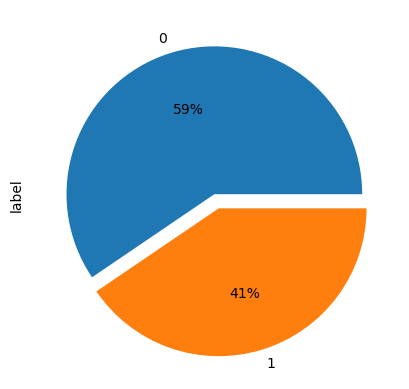

In [6]:
df.label.value_counts().plot.pie(explode=[0,0.1], autopct='%.0f%%')
plt.show()

> We can see that the set skews heavier to negative samples.

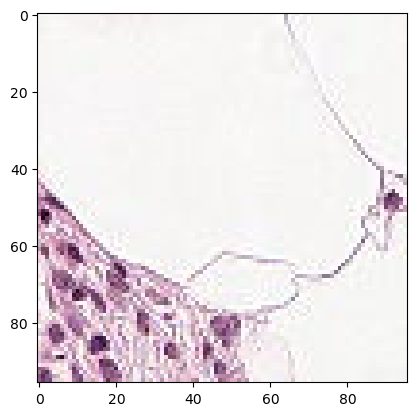

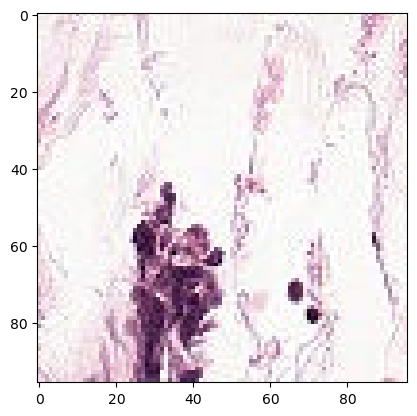

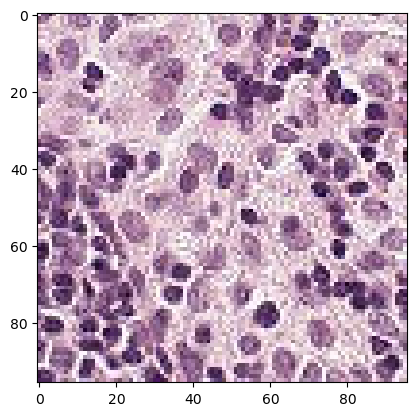

In [7]:
# check to see what images look like
# (according to df.head, secong image is positive for example)
for i in range(3):
    img_file = "D:\\histopathologic-cancer-detection\\train\\"+str(df.iloc[i,0])+".tif"
    plt.imshow(imread(img_file))
    plt.show()

> This competition only looks at the middle 32x32 section of each image, so the full images above haven't been considered for labelling. We can observe that the images are in color and the model will take that into account.

### Data Preparation

There isn't a need for much cleaning beyond setting up the data to work with Keras. A few tasks need to be done: convert the labels to string; add the .tif file extension to the image ids; and rescale the rgb data from the image files

In [6]:
# for compatibility, id must be full filename with extension 
#   and label should be string
df['label'] = df['label'].astype(str)

def append_ext(fn):
    return fn+".tif"
df['id'] = df['id'].apply(append_ext)

In [7]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


> file extension is missing from the id and will need to be added later (at least to run on with my system configurations)

In [8]:
# ORIGINAL
datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                        validation_split=0.3)

train_generator=datagen.flow_from_dataframe(
    directory = r'D:\\histopathologic-cancer-detection\\train',
    dataframe=df, 
    x_col="id", 
    y_col="label", 
    subset="training",
    seed=13,
    shuffle=True,
    class_mode="binary", 
    target_size=(96,96), 
    batch_size=64)

Found 154018 validated image filenames belonging to 2 classes.


In [9]:
valid_generator=datagen.flow_from_dataframe(
    directory = r'D:\\histopathologic-cancer-detection\\train',
    dataframe=df, 
    x_col="id", 
    y_col="label", 
    subset="validation",
    seed=13,
    shuffle=True,
    class_mode="binary", 
    target_size=(96,96), 
    batch_size=64)

Found 66007 validated image filenames belonging to 2 classes.


In [10]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

## Analysis: Model Building & Training
Using Keras and splitting out a validation set from the training. We will start with a very simple model and add to it to see what changes positively impact the performance of the model.

This first model will only have one convolutional layer. And will only be trained on a single epoch.

In [11]:
# basic model with single convolutional layer
model_simple = Sequential()
model_simple.add(CenterCrop(32,32)) # only checking 32x32 center region
model_simple.add(Conv2D(16, (3, 3), padding='same'))
model_simple.add(Activation('relu'))
model_simple.add(Flatten())
model_simple.add(Dense(256, activation='relu'))
model_simple.add(Dense(1, activation='sigmoid'))
model_simple.compile(optimizers.Adam(learning_rate=0.0001),
                     loss="binary_crossentropy",
                     metrics=["accuracy",tf.keras.metrics.AUC()])

In [12]:
fit_simple = model_simple.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=1)

2406/2406 [==============================] - 5830s 2s/step - loss: 0.5105 - accuracy: 0.7569 - auc: 0.8198 - val_loss: 0.4895 - val_accuracy: 0.7733 - val_auc: 0.8385


> As AUC is the metric chosen for the competition that will be the primary focus for comparing our models. Here we've reached **0.8385** for validation AUC, which seems like a good start.

In [13]:
# check effect of adding a second convolutional layer
mod2 = Sequential()
mod2.add(CenterCrop(32,32))
mod2.add(Conv2D(16, (3, 3), padding='same'))
mod2.add(Activation('relu'))
mod2.add(Conv2D(16, (3, 3), padding='same')) # adding identical second convolutional layer
mod2.add(Activation('relu'))
mod2.add(Flatten())
mod2.add(Dense(256, activation='relu'))
mod2.add(Dense(1, activation='sigmoid'))
mod2.compile(optimizers.Adam(learning_rate=0.0001),
             loss="binary_crossentropy",
             metrics=["accuracy",tf.keras.metrics.AUC()])

In [14]:
fit2 = mod2.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=1)

2406/2406 [==============================] - 2208s 917ms/step - loss: 0.5046 - accuracy: 0.7607 - auc_1: 0.8245 - val_loss: 0.4907 - val_accuracy: 0.7727 - val_auc_1: 0.8395


> A slight improvement to the validation AUC (**0.8395** vs 0.8385). On its own, this isn't a conclusive improvement but most of the other metrics improved as well

In [15]:
# check effect of a more complicated model with pooling and third convolutional layer
mod3 = Sequential()
mod3.add(CenterCrop(32,32))
mod3.add(Conv2D(16, (3, 3), padding='same'))
mod3.add(Activation('relu'))
mod3.add(Conv2D(16, (3, 3), padding='same')) 
mod3.add(Activation('relu'))
mod3.add(MaxPooling2D(pool_size=(2,2))) # adding pooling layer to simplify
mod3.add(Conv2D(32, (3, 3), padding='same')) #adding 3rd conv layer
mod3.add(Flatten())
mod3.add(Dense(256, activation='relu'))
mod3.add(Dense(1, activation='sigmoid'))
mod3.compile(optimizers.Adam(learning_rate=0.0001),
             loss="binary_crossentropy",
             metrics=["accuracy",tf.keras.metrics.AUC()])

In [16]:
fit3 = mod3.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=1)

2406/2406 [==============================] - 2927s 1s/step - loss: 0.5014 - accuracy: 0.7630 - auc_2: 0.8265 - val_loss: 0.4846 - val_accuracy: 0.7736 - val_auc_2: 0.8489


> Introducing a third pooling layer and a MaxPooling layer yieded a notable improvement with validation AUC now at **0.8489**.

In [17]:
# check effect of a dropout layer on validation performance
mod4 = Sequential()
mod4.add(CenterCrop(32,32))
mod4.add(Conv2D(16, (3, 3), padding='same'))
mod4.add(Activation('relu'))
mod4.add(Conv2D(16, (3, 3), padding='same')) 
mod4.add(Activation('relu'))
mod4.add(MaxPooling2D(pool_size=(2,2)))
mod4.add(Dropout(0.1)) # add dropout layer to regularize
mod4.add(Conv2D(32, (3, 3), padding='same'))
mod4.add(Flatten())
mod4.add(Dense(256, activation='relu'))
mod4.add(Dense(1, activation='sigmoid'))
mod4.compile(optimizers.Adam(learning_rate=0.0001),
             loss="binary_crossentropy",
             metrics=["accuracy",tf.keras.metrics.AUC()])

In [18]:
fit4 = mod4.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=1)

2406/2406 [==============================] - 2879s 1s/step - loss: 0.5052 - accuracy: 0.7596 - auc_3: 0.8237 - val_loss: 0.4816 - val_accuracy: 0.7719 - val_auc_3: 0.8466


*This* implementation of a dropout layer wasn't successful. Only the validation loss improved. Regularization (if any) came at the expense of overall performance.

However, we've only trained on a single epoch so overtraining is less likely than it would have with a more appropriate training length. Regularization seems like an important inclusion.

In [19]:
#try training over several additional epochs to see effect of further training
fit4x = mod4.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=5)

Epoch 1/5
2406/2406 [==============================] - 2909s 1s/step - loss: 0.4643 - accuracy: 0.7860 - auc_3: 0.8532 - val_loss: 0.4487 - val_accuracy: 0.7952 - val_auc_3: 0.8631
Epoch 2/5
2406/2406 [==============================] - 2892s 1s/step - loss: 0.4478 - accuracy: 0.7966 - auc_3: 0.8640 - val_loss: 0.4510 - val_accuracy: 0.7939 - val_auc_3: 0.8663
Epoch 3/5
2406/2406 [==============================] - 3067s 1s/step - loss: 0.4389 - accuracy: 0.8012 - auc_3: 0.8700 - val_loss: 0.4418 - val_accuracy: 0.7996 - val_auc_3: 0.8686
Epoch 4/5
2406/2406 [==============================] - 3332s 1s/step - loss: 0.4309 - accuracy: 0.8052 - auc_3: 0.8752 - val_loss: 0.4288 - val_accuracy: 0.8059 - val_auc_3: 0.8765
Epoch 5/5
2406/2406 [==============================] - 2894s 1s/step - loss: 0.4216 - accuracy: 0.8103 - auc_3: 0.8811 - val_loss: 0.4199 - val_accuracy: 0.8123 - val_auc_3: 0.8817


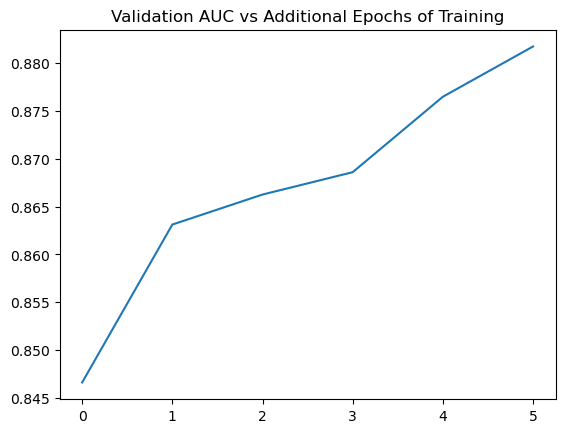

In [21]:
plt.plot(fit4.history['val_auc_3']+fit4x.history['val_auc_3'])
plt.title("Validation AUC vs Additional Epochs of Training")
plt.show()

> An additional five epochs of training bring our validation AUC to **0.8817**. The trend hasn't slowed, suggesting the further training could yield significant improvements. However, at about 1hr per epoch, I won't pursue this for the moment.

Before investigating a further training or adding additional convolutional layers, it seems worthwhile to experiment with kernel size. Next will will explore using a 5x5 kernel in place of the previous 3x3 in the first convolutional layer.

In [25]:
# check effect of a larger kernel size
mod5 = Sequential()
mod5.add(CenterCrop(32,32))
mod5.add(Conv2D(16, (5, 5), padding='same')) # 5x5 instead of 3x3
mod5.add(Activation('relu'))
mod5.add(MaxPooling2D(pool_size=(2,2)))
mod5.add(Conv2D(32, (3, 3), padding='same')) 
mod4.add(Activation('relu'))
mod5.add(BatchNormalization()) # adding a batch normalization layer as model is 
mod5.add(MaxPooling2D(pool_size=(2,2)))
mod5.add(Dropout(0.1))
mod5.add(Conv2D(64, (3, 3), padding='same'))
mod5.add(Flatten())
mod5.add(Dense(256, activation='relu'))
mod5.add(Dense(1, activation='sigmoid'))
mod5.compile(optimizers.Adam(learning_rate=0.0001),
             loss="binary_crossentropy",
             metrics=["accuracy",tf.keras.metrics.AUC()])

In [26]:
fit5 = mod5.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=1)

2406/2406 [==============================] - 2876s 1s/step - loss: 0.4769 - accuracy: 0.7786 - auc_4: 0.8440 - val_loss: 0.4604 - val_accuracy: 0.7885 - val_auc_4: 0.8595


> Our validation AUC of **0.8595**t suggests that larger scale patterns may have been overlooked in the earlier models.

In [27]:
# check effect of an EVEN larger kernel size
mod6 = Sequential()
mod6.add(CenterCrop(32,32))

mod6.add(Conv2D(16, (7, 7), padding='same')) # 7x7 instead of 5x5
mod6.add(Activation('relu'))
mod6.add(MaxPooling2D(pool_size=(2,2)))

mod6.add(Conv2D(32, (3, 3), padding='same')) 
mod6.add(Activation('relu'))
mod6.add(MaxPooling2D(pool_size=(2,2)))

mod6.add(BatchNormalization())
mod6.add(Dropout(0.1))

mod6.add(Conv2D(64, (3, 3), padding='same')) 
mod6.add(Activation('relu'))
mod6.add(MaxPooling2D(pool_size=(2,2)))

mod6.add(Dropout(0.1))
mod6.add(Conv2D(64, (3, 3), padding='same'))
mod6.add(Flatten())
mod6.add(Dense(256, activation='relu'))
mod6.add(Dense(1, activation='sigmoid'))
mod6.compile(optimizers.Adam(learning_rate=0.0001),
             loss="binary_crossentropy",
             metrics=["accuracy",tf.keras.metrics.AUC()])

In [29]:
fit6 = mod6.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=1)

2406/2406 [==============================] - 4176s 2s/step - loss: 0.4725 - accuracy: 0.7832 - auc_5: 0.8464 - val_loss: 0.4810 - val_accuracy: 0.7844 - val_auc_5: 0.8503


> Here the validation metrics are worse, but the training metrics have improved.

The next few models will explore different filter sizes and play with padding options to incorporate real data around the analysis region.

In [36]:
# check effect of a larger kernel size with strides
mod7 = Sequential()
mod7.add(CenterCrop(32,32))

mod7.add(Conv2D(16, (8, 8), padding='same', strides=(2,2))) # 8x8 with stride of 2
mod7.add(Activation('relu'))

mod7.add(Conv2D(32, (3, 3), padding='same')) 
mod7.add(Activation('relu'))
mod7.add(MaxPooling2D(pool_size=(2,2)))

mod7.add(BatchNormalization())
mod7.add(Dropout(0.1))

mod7.add(Conv2D(64, (3, 3), padding='same')) 
mod7.add(Activation('relu'))
mod7.add(MaxPooling2D(pool_size=(2,2)))

mod7.add(Dropout(0.1))
mod7.add(Conv2D(64, (3, 3), padding='same'))
mod7.add(Flatten())
mod7.add(Dense(256, activation='relu'))
mod7.add(Dense(1, activation='sigmoid'))
mod7.compile(optimizers.Adam(learning_rate=0.0001),
             loss="binary_crossentropy",
             metrics=["accuracy",tf.keras.metrics.AUC()])

In [37]:
fit7 = mod7.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=1)

2406/2406 [==============================] - 3057s 1s/step - loss: 0.4809 - accuracy: 0.7773 - auc_9: 0.8406 - val_loss: 0.4554 - val_accuracy: 0.7965 - val_auc_9: 0.8599


In [34]:
# check effect of a larger kernel size & eliminating zero-padding
mod8 = Sequential()
mod8.add(CenterCrop(38,38)) # 32x32 +3 per side to accomodate stride of 2

mod8.add(Conv2D(16, (8, 8), padding='valid', strides=(2,2)))
mod8.add(Activation('relu'))

mod8.add(Conv2D(32, (3, 3), padding='same')) 
mod8.add(Activation('relu'))
mod8.add(MaxPooling2D(pool_size=(2,2)))

mod8.add(BatchNormalization())
mod8.add(Dropout(0.1))

mod8.add(Conv2D(64, (3, 3), padding='same')) 
mod8.add(Activation('relu'))
mod8.add(MaxPooling2D(pool_size=(2,2)))

mod8.add(Dropout(0.1))
mod8.add(Conv2D(64, (3, 3), padding='same'))
mod8.add(Flatten())
mod8.add(Dense(256, activation='relu'))
mod8.add(Dense(1, activation='sigmoid'))
mod8.compile(optimizers.Adam(learning_rate=0.0001),
             loss="binary_crossentropy",
             metrics=["accuracy",tf.keras.metrics.AUC()])

In [35]:
fit8 = mod8.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=1)

2406/2406 [==============================] - 3017s 1s/step - loss: 0.4746 - accuracy: 0.7814 - auc_8: 0.8456 - val_loss: 0.5593 - val_accuracy: 0.7461 - val_auc_8: 0.8022


In [38]:
# check effect of an even larger kernel size
mod9 = Sequential()
mod9.add(CenterCrop(38,38)) # 32x32 + 3 per side for padding

mod9.add(Conv2D(16, (7, 7), padding='valid')) # 7x7 instead of 5x5
mod9.add(Activation('relu'))
mod9.add(MaxPooling2D(pool_size=(2,2)))

mod9.add(Conv2D(32, (3, 3), padding='same')) 
mod9.add(Activation('relu'))
mod9.add(MaxPooling2D(pool_size=(2,2)))

mod9.add(BatchNormalization())
mod9.add(Dropout(0.1))

mod9.add(Conv2D(64, (3, 3), padding='same')) 
mod9.add(Activation('relu'))
mod9.add(MaxPooling2D(pool_size=(2,2)))

mod9.add(Dropout(0.1))
mod9.add(Conv2D(64, (3, 3), padding='same'))
mod9.add(Flatten())
mod9.add(Dense(256, activation='relu'))
mod9.add(Dense(1, activation='sigmoid'))
mod9.compile(optimizers.Adam(learning_rate=0.0001),
             loss="binary_crossentropy",
             metrics=["accuracy",tf.keras.metrics.AUC()])

In [39]:
fit9 = mod9.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=1)

2406/2406 [==============================] - 3041s 1s/step - loss: 0.4715 - accuracy: 0.7822 - auc_10: 0.8472 - val_loss: 0.4985 - val_accuracy: 0.7564 - val_auc_10: 0.8662


> This is the most successful of the models. Here padding is provided by image data surrounded the target region. The first convolutional layer is 7x7 and regularization is incorporated.

In [45]:
fit9x = mod9.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=7)

Epoch 1/7
2406/2406 [==============================] - 3115s 1s/step - loss: 0.4395 - accuracy: 0.8032 - auc_10: 0.8691 - val_loss: 0.5062 - val_accuracy: 0.7685 - val_auc_10: 0.8356
Epoch 2/7
2406/2406 [==============================] - 2811s 1s/step - loss: 0.4263 - accuracy: 0.8093 - auc_10: 0.8778 - val_loss: 0.4169 - val_accuracy: 0.8134 - val_auc_10: 0.8838
Epoch 3/7
2406/2406 [==============================] - 3505s 1s/step - loss: 0.4162 - accuracy: 0.8145 - auc_10: 0.8840 - val_loss: 0.5275 - val_accuracy: 0.7512 - val_auc_10: 0.8613
Epoch 4/7
2406/2406 [==============================] - 3984s 2s/step - loss: 0.4059 - accuracy: 0.8206 - auc_10: 0.8901 - val_loss: 0.4433 - val_accuracy: 0.7996 - val_auc_10: 0.8768
Epoch 5/7
2406/2406 [==============================] - 3415s 1s/step - loss: 0.3959 - accuracy: 0.8247 - auc_10: 0.8958 - val_loss: 0.3884 - val_accuracy: 0.8280 - val_auc_10: 0.9032
Epoch 6/7
2406/2406 [==============================] - 3781s 2s/step - loss: 0.3880 -

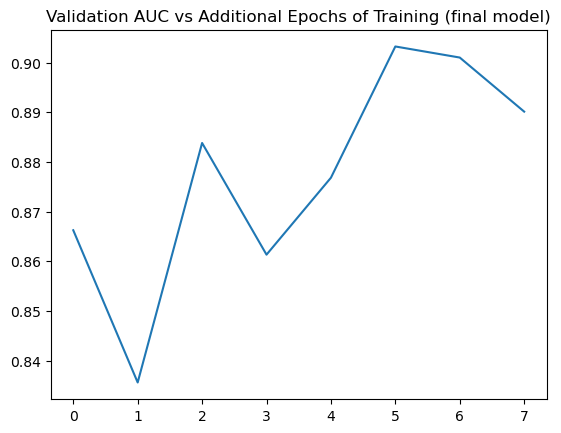

In [24]:
plt.plot(fit9_history['val_auc_10']+fit9x_history['val_auc_10'])
plt.title("Validation AUC vs Additional Epochs of Training (final model)")
plt.show()

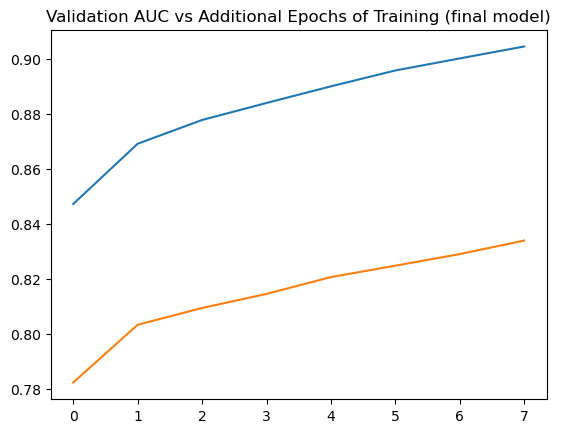

In [25]:
plt.plot(fit9_history['auc_10']+fit9x_history['auc_10'])
plt.plot(fit9_history['accuracy']+fit9x_history['accuracy'])
plt.title("Validation AUC vs Additional Epochs of Training (final model)")
plt.show()

> Performance on the training set improved with each epoch of training. Unfortunately the Validation AUC fluctuated.

## Result

Next, we will apply our models to the test imageset and submit the results to Kaggle for scoring.

In [51]:
# Prepare test generator
test_df = pd.read_csv(r'D:\\histopathologic-cancer-detection\\sample_submission.csv')
test_df['label'] = test_df['label'].astype(str)
test_df['id'] = test_df['id'].apply(append_ext)

test_df.head(1)

test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_dataframe(
    directory = r'D:\\histopathologic-cancer-detection\\test',
    dataframe=test_df, 
    x_col="id", 
    y_col="label", 
    seed=13,
    shuffle=False, # Don't shuffle
    class_mode=None, 
    target_size=(96,96),
    batch_size=64)

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 57458 validated image filenames.


Submit results from Model 4 (highest performing 3x3 model):

In [56]:
pred4x = mod4.predict(test_generator)
pred4x

898/898 [==============================] - 73s 81ms/step


array([[0.05123634],
       [0.14338323],
       [0.07499482],
       ...,
       [0.08777443],
       [0.0716933 ],
       [0.02456372]], dtype=float32)

In [61]:
pred4xdf = pd.read_csv(r'D:\\histopathologic-cancer-detection\\sample_submission.csv')
pred4xdf.label = pred4x.round().astype(int).flatten()
pred4xdf.to_csv('submission4x.csv', index=False)

> 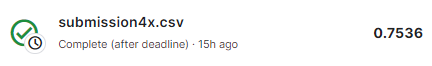

In [52]:
pred9x = mod9.predict(test_generator)
pred9xdf = pd.read_csv(r'D:\\histopathologic-cancer-detection\\sample_submission.csv')
pred9xdf.label = pred9x.round().astype(int).flatten()
pred9xdf.to_csv('submission9x.csv', index=False)

898/898 [==============================] - 281s 314ms/step


> 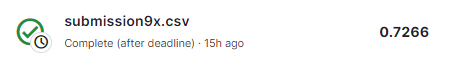

Recalling that it's the AUC that is being evaluated, we should *not* be converting our output to binary predictions and should instead be submitting the raw predictions (probabilities):

In [53]:
pred9xdf.label = pred9x.flatten()
pred9xdf.to_csv('submission9x-noround.csv', index=False)

> 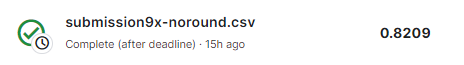
> A notable improvement

## Discussion/conclusion
Other than additional training epochs, the biggest improvement to the model came from increasing the kernel size (presumably allowing the model to account for larger-scale patterns).

Surprisingly, we weren't able to observe provable improvements on validation performance when using dropout as a regularization technique (nor was it *clear* that it was worse).

If I were to start again, I would begin with a smaller training set as each epoch took an hour to run and thus slowed progress and reduced the number of models that could be attempted.